In [96]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

sns.set_style("darkgrid")
float_formatter = "{:.3}".format
np.set_printoptions(formatter={"float_kind": float_formatter})


In [242]:
def dict_factory(cursor, row):
    col_names = [col[0] for col in cursor.description]
    return {key: value for key, value in zip(col_names, row)}


with sqlite3.connect("games2") as con:
    con.row_factory = dict_factory
    # new
    query3 = """
        SELECT
            g.result,
            p.eval,
            p.ply,
            g.elo_white,
            g.elo_black
        FROM
            games g INNER JOIN positions p
            ON g.rowid = p.game_id
        WHERE
            g.result != 3
            AND p.eval is not NULL
            AND p.eval < 9900
            AND p.eval > -9900
        """

    # query1 = """
    #     SELECT 
    #         g.result,
    #         m.eval,
    #         m.ply
    #     FROM 
    #         games g INNER JOIN moves m 
    #         ON g.url = m.url
    #     WHERE
    #         g.result != 3
    #         AND m.eval is not NULL
    #         AND m.eval < 9900
    #         AND m.eval > -9900
    #     """



    # query2 = """
    #     SELECT 
    #         g.result,
    #         MIN(m.eval) as eval_min,
    #         MAX(m.eval) as eval_max,
    #         AVG(m.eval) as eval_avg
    #     FROM 
    #         games g INNER JOIN moves m 
    #         ON g.url = m.url
    #     WHERE
    #         g.result != 3
    #         AND m.eval is not NULL
    #         AND m.eval < 9900
    #         AND m.eval > -9900
    #     GROUP BY g.url
    #     """

    res = con.execute(query3)
    df = pd.DataFrame(res)

con.close()


In [272]:
random_state = 42

features = [
    "eval",
    "ply",
    "elo_black",
    "elo_white",
]
# features = ["eval_min", "eval_max"]
X = df.loc[:, features]
y = df.result

classifier = LogisticRegression(
    # Cs=20,
    random_state=random_state,
    n_jobs=-1,
    # penalty="elasticnet",
    # solver="saga",
    # l1_ratios=np.linspace(0, 1, num=20),
    # class_weight="balanced",
)
scaler = StandardScaler()
model = make_pipeline(scaler, classifier)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=random_state, stratify=y
)


<AxesSubplot: xlabel='elo_white', ylabel='result'>

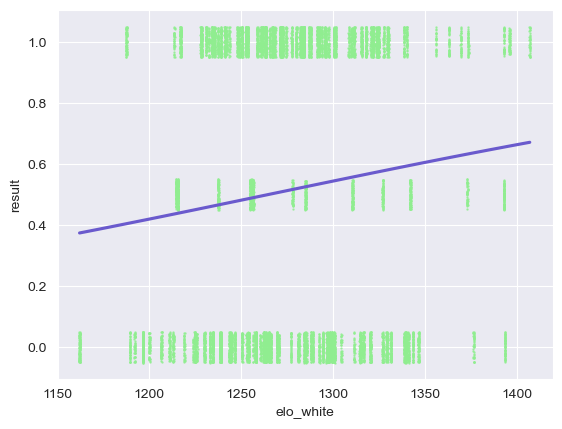

In [273]:
sns.regplot(
    data=(df + 1) / 2,
    x="elo_white",
    y="result",
    y_jitter=0.05,
    x_jitter=0.2,
    logistic=True,
    n_boot=1,
    ci=1,
    scatter_kws={"s": 0.5, "color": "lightgreen"},
    color="slateblue",
)


In [274]:
model.fit(X_train, y_train)

print(f"Accuracy: \n {model.score(X_test, y_test)}")
coefs = (
    model.named_steps["logisticregression"].coef_
    / model.named_steps["standardscaler"].scale_
)
print(f"Coefficients: \n {coefs}")

intercept = model.named_steps["logisticregression"].coef_
print(f"Intercept: \n {intercept}")

cs = model.named_steps["logisticregression"].C_
cs


Accuracy: 
 0.6742973051289481
Coefficients: 
 [[-0.00191 -0.00759 0.00562 -0.00437]
 [0.000133 0.014 -0.00156 0.00156]
 [0.00177 -0.00636 -0.00406 0.00281]]
Intercept: 
 [[-1.54 -0.218 0.546 -0.382]
 [0.108 0.4 -0.152 0.136]
 [1.44 -0.182 -0.394 0.245]]


AttributeError: 'LogisticRegression' object has no attribute 'C_'

<AxesSubplot: xlabel='ply', ylabel='eval'>

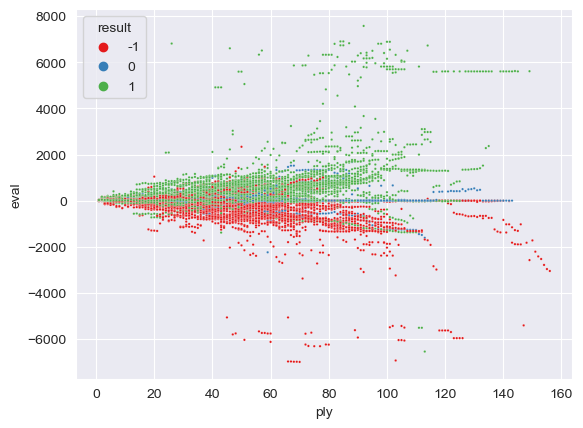

In [ ]:
sns.scatterplot(
    df,
    x="ply",
    y="eval",
    hue="result",
    s=3,
    palette="Set1",
)


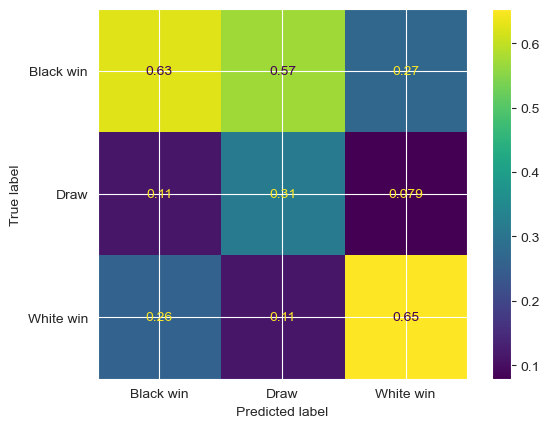

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    normalize="pred",
    display_labels=[
        "Black win",
        "Draw",
        "White win",
    ],
)


In [ ]:
model.predict_proba([[0, 10, 2300, 2300]])

c:\tools\miniconda3\envs\py310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: X has 4 features, but StandardScaler is expecting 2 features as input.

In [ ]:
df.groupby("result").count()

,eval,ply,elo_white,elo_black
result,,,,
-1,6024,6024,6024,6024
0,1349,1349,1349,1349
1,6431,6431,6431,6431
